In [ ]:
# pip install clean-text==0.6.0

In [ ]:
# pip install unidecode

In [ ]:
# pip install -r requirements.txt

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from deployment import preprocess, detect
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from tqdm.auto import tqdm
import logging

In [2]:
def stratified_split(df):

    # Handle NaN values in 'LLM_model' where 'write_by' is 'Human'
    df['LLM_model'] = df.apply(lambda x: 'No_LLM' if pd.isna(x['LLM_model']) and x['write_by'] == 'Human' else x['LLM_model'], axis=1)

    # Define stratification criteria
    stratify_criteria = df[['write_by', 'language', 'domain', 'LLM_model']]

    # Split the dataset into training (70%), and a temporary set (30%)
    df_train, df_temp = train_test_split(df, test_size=0.30, stratify=stratify_criteria, random_state=42)

    # Split the temporary set into validation (10% of the original set) and test (20% of the original set)
    df_val, df_test = train_test_split(df_temp, test_size=2/3, stratify=stratify_criteria.loc[df_temp.index], random_state=42)

    # Return the dataframes
    return df_train, df_val, df_test


#---------------------------------------------------------------------

# Define paths
path_colab = '/content/drive/MyDrive/Colab Notebooks/Models/Multi_Model/'
path_notebook = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/3_Final_Dataset/'

# Toggle this to switch between Colab and local notebook paths
use_colab = False

# Set the base path based on the flag
base_path = path_colab if use_colab else path_notebook

#---------------------------------------------------------------------

# Helper function to read datasets
def load_dataset(file_name):
    return pd.read_csv(base_path + file_name)

#---------------------------------------------------------------------

df = load_dataset('Multi_Model_Multi_Lingual.csv')
df_train, df_val, df_test = stratified_split(df)

In [3]:
def plot_roc_curve(final_labels, probabilities, filename="roc_curve.png"):
    # Calculate the ROC curve points
    fpr, tpr, thresholds = roc_curve(final_labels, probabilities)
    roc_auc = auc(fpr, tpr)  # Calculate the AUC of the ROC

    # Setting up the plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for DeepfakeTextDetect Longformer (Modified)', fontsize=12, weight='bold')
    plt.legend(loc="lower right")

    # Save the plot to a file
    plt.savefig(filename, format='png', bbox_inches='tight', dpi=300)
    plt.show()


Processing Texts:   0%|          | 0/4789 [00:00<?, ?it/s]

Initializing global attention on CLS token...
Input ids are automatically padded from 893 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 806 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 110 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 708 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 553 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 135 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 93 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 161 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 97 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded

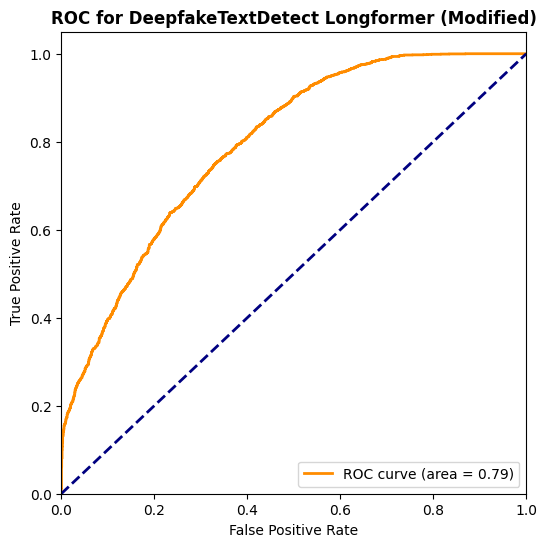

In [4]:
# Initialize results list
results = []

# Suppress the padding information
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

def evaluate_model_performance(df, text_column, label_column, language_column, model_dir, device='cuda:0'):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    
    # Create a progress bar for the DataFrame processing
    tqdm.pandas(desc="Processing Texts")

    # Preprocess and detect the label and probabilities for each text entry with progress bar
    df['predicted_label'], df['probabilities'] = zip(*df.progress_apply(lambda x: detect(preprocess(x[text_column], x[language_column]), tokenizer, model, device), axis=1))
    
    # Map predicted labels from text to integers
    label_mapping = {'machine-generated': 0, 'human-written': 1}
    df['predicted_label'] = df['predicted_label'].map(label_mapping)
    
    # Calculate metrics
    roc_auc = roc_auc_score(df[label_column], df['probabilities'])  
    f1 = f1_score(df[label_column], df['predicted_label'])
    precision = precision_score(df[label_column], df['predicted_label'])
    recall = recall_score(df[label_column], df['predicted_label'])
    accuracy = accuracy_score(df[label_column], df['predicted_label'])

    # Compile metrics into a dictionary
    metrics = {
        'AUROC': roc_auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
    }

    # Plot ROC curve for test set
    plot_roc_curve(df[label_column], df['probabilities'], "roc_deepfaketextdetect_longformer_modified.png")
    
    return df, metrics

# Model details
model_directory = "nealcly/detection-longformer"
model_name = "DeepfakeTextDetect_Longformer_(Modified)"
text_col = 'text'  
label_col = 'label'  
language_col = 'language'  

# Run model evaluation
df_results, test_metrics = evaluate_model_performance(df_test, text_col, label_col, language_col, model_directory)

# Append results to the results list
results.append([
    model_name, 
    'External Test', 
    test_metrics['Accuracy'], 
    test_metrics['F1'], 
    test_metrics['AUROC']
])


In [5]:
results_for_csv = []
for result in results:
    filtered_result = [
        result[0],  # Model Name
        result[1],  # Test Type
        round(result[2], 3),  # Accuracy
        round(result[3], 3),  # F1 Score
        round(result[4], 3)   # AUROC
    ]
    results_for_csv.append(filtered_result)

# Create DataFrame from filtered results with rounded numbers
results_df = pd.DataFrame(results_for_csv, columns=['Model', 'Test Type', 'Accuracy', 'F1 Score', 'AUROC'])


# Update the path to where you want to save your file, adjusting for your environment
results_csv_path = 'deepfaketextdetect_modified_evaluation_results.csv'
results_df.to_csv(results_csv_path, index=False)


In [6]:
results_df = pd.read_csv('deepfaketextdetect_modified_evaluation_results.csv')

In [3]:
def modify_model_name(model_name):
    parts = model_name.split('_')
    new_name = ' '.join(parts)
    return new_name

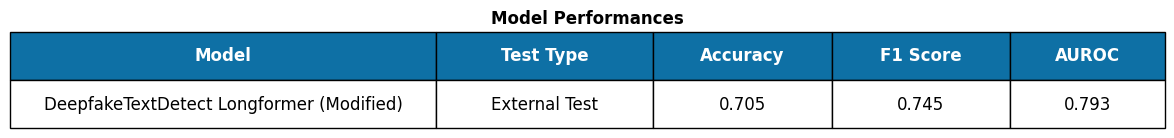

In [12]:
def render_mpl_table(data, row_height=0.625, font_size=12,
                     header_color='#0e70a5', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if "Model trained on" not in data['Model'].iloc[0]:
        data['Model'] = data['Model'].apply(modify_model_name)

    # Calculate the maximum string length for each column and apply padding
    padding = 15  # Define padding size
    col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(col)) + padding for col in data.columns]
    col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

    if ax is None:
        size = (np.array([sum(col_widths), data.shape[0]+1]) * np.array([1, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         colWidths=col_widths, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)  
        cell.set_text_props(ha='center')  
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    return ax


render_mpl_table(results_df, header_columns=0)
plt.title('Model Performances', fontsize=12, weight='bold')
plt.savefig('deepfaketextdetect_modified_evaluation_table.png', bbox_inches='tight', dpi=300)
plt.show()


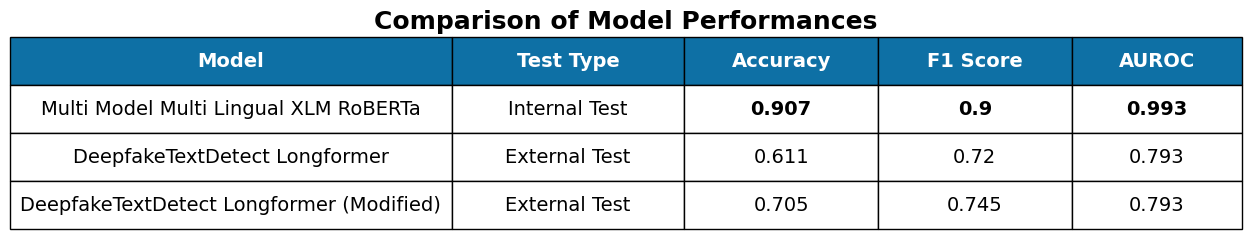

In [5]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#0e70a5', row_color='w', edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    # Apply model name modification
    data['Model'] = data['Model'].apply(modify_model_name)

    # Convert relevant columns to float
    data[['Accuracy', 'F1 Score', 'AUROC']] = data[['Accuracy', 'F1 Score', 'AUROC']].astype(float)

    if ax is None:
        # Calculate column widths based on content width and add padding
        padding = 17  # Define padding size
        col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(col)) + padding for col in data.columns]
        col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

        size = (np.array([sum(col_widths), len(data) + 1]) * np.array([1, row_height])).tolist()
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         cellLoc='center', loc='center', colWidths=col_widths, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    mpl_table.scale(1, 1.5)

    # Identify maximum values for specified columns
    max_values = {col: data[col].max() for col in ['Accuracy', 'F1 Score', 'AUROC']}
    # Set cell colors
    for i in range(len(data.values)): 
        for j in range(len(data.columns)):
            cell = mpl_table[(i, j)]
            if i == 0:
                cell.set_facecolor(header_color)
                cell.set_text_props(weight='bold', color='w')
            else:
                cell.set_facecolor(row_color)
    
    # Apply bold font style for maximum values
    for (i, j), val in np.ndenumerate(data.values):
        cell = mpl_table[(i+1, j)]  # Adjust the index to include the header row
        if data.columns[j] in ['Accuracy', 'F1 Score', 'AUROC'] and float(val) == max_values[data.columns[j]]:
            cell.get_text().set_weight('bold')

    return fig, ax

# Load and combine data
df1 = pd.read_csv('multi_model_multi_lingual_evaluation_results.csv')
df2 = pd.read_csv('deepfaketextdetect_evaluation_results.csv')
df3 = pd.read_csv('deepfaketextdetect_modified_evaluation_results.csv')

# Concatenate all three dataframes and reset the index
results_df = pd.concat([df1, df2, df3]).reset_index(drop=True)

# Render and save the table
fig, ax = render_mpl_table(results_df, header_columns=0)
plt.title('Comparison of Model Performances', fontsize=18, weight='bold')
plt.savefig('model_performance_comparison.png', bbox_inches='tight', dpi=300)
plt.show()
